# 🧠 CNN for Image Classification (MNIST Dataset)

**Objective:**  
In this notebook, we build and train a simple Convolutional Neural Network (CNN) to classify handwritten digits (0–9) using the **MNIST dataset**.

We will:
1. Set up our environment and import libraries  
2. Load and preprocess the MNIST dataset  
3. Split data into **70% train**, **15% validation**, **15% test**  
4. Build a CNN according to assignment specifications  
5. Train for 20 epochs and plot training/validation loss  
6. Compare optimizers — **Adam**, **SGD**, **SGD with Momentum**  
7. Evaluate using accuracy, precision, recall, and confusion matrix  
8. Discuss the effect of the momentum parameter


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import random, os

## Set Random Seed
For consistent results each time the notebook runs, we fix random seeds for NumPy, TensorFlow, and Python.

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## 📊 Load and Prepare the MNIST Dataset

**Note:**  
The MNIST dataset is originally hosted on the UCI Machine Learning Repository:  
https://archive.ics.uci.edu/dataset/683/mnist+database+of+handwritten+digits  
For convenience, we use the Keras-provided MNIST dataset, which is equivalent 
and allows easy loading and preprocessing in Python.

We use the **MNIST** handwritten digits dataset from Keras.  
It contains **70,000 grayscale images (28×28)** across 10 classes (digits 0–9).

We combine all data, normalize pixel values to [0,1], and split into:
- **70% Training**
- **15% Validation**
- **15% Testing**

In [7]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Combine training and test sets
X = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# Normalize and reshape
X = X.astype("float32") / 255.0
X = np.expand_dims(X, -1)

# Split 70/15/15
train_size = 0.70
val_size = 0.15 / (1 - train_size)

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, train_size=val_size, stratify=y_rem, random_state=42)

# One-hot encode
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (49000, 28, 28, 1)
Val:   (10499, 28, 28, 1)
Test:  (10501, 28, 28, 1)


##  Build the CNN Model

### Architecture (as per assignment):
1. **Conv2D layer 1:** 32 filters, 3×3 kernel, ReLU  
2. **MaxPooling2D**
3. **Conv2D layer 2:** 64 filters, 3×3 kernel, ReLU  
4. **MaxPooling2D**
5. **Flatten**
6. **Dense layer:** 128 units, ReLU  
7. **Dropout:** 0.5  
8. **Output layer:** 10 units, Softmax

### Activation Justification:
- **ReLU:** avoids vanishing gradients, speeds convergence  
- **Softmax:** converts final layer outputs into class probabilities

In [4]:
def build_model(input_shape=(28,28,1), num_classes=10):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model()
model.summary()

c:\Users\Jesut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

##  Training the Model (Adam Optimizer)
We train the model for **20 epochs** using:
- Optimizer: **Adam** (learning_rate = 1e-3)  
- Loss: Categorical Crossentropy  
- Metric: Accuracy  

We also plot the training and validation loss per epoch.

Epoch 1/20
383/383 - 8s - 22ms/step - accuracy: 0.9089 - loss: 0.3002 - val_accuracy: 0.9728 - val_loss: 0.0833 - learning_rate: 1.0000e-03
Epoch 2/20
383/383 - 8s - 20ms/step - accuracy: 0.9699 - loss: 0.0998 - val_accuracy: 0.9829 - val_loss: 0.0555 - learning_rate: 1.0000e-03
Epoch 3/20
383/383 - 11s - 28ms/step - accuracy: 0.9789 - loss: 0.0717 - val_accuracy: 0.9853 - val_loss: 0.0499 - learning_rate: 1.0000e-03
Epoch 4/20
383/383 - 11s - 28ms/step - accuracy: 0.9810 - loss: 0.0608 - val_accuracy: 0.9869 - val_loss: 0.0435 - learning_rate: 1.0000e-03
Epoch 5/20
383/383 - 14s - 38ms/step - accuracy: 0.9847 - loss: 0.0493 - val_accuracy: 0.9890 - val_loss: 0.0390 - learning_rate: 1.0000e-03
Epoch 6/20
383/383 - 11s - 30ms/step - accuracy: 0.9872 - loss: 0.0425 - val_accuracy: 0.9891 - val_loss: 0.0373 - learning_rate: 1.0000e-03
Epoch 7/20
383/383 - 12s - 31ms/step - accuracy: 0.9890 - loss: 0.0358 - val_accuracy: 0.9894 - val_loss: 0.0395 - learning_rate: 1.0000e-03
Epoch 8/20
383/

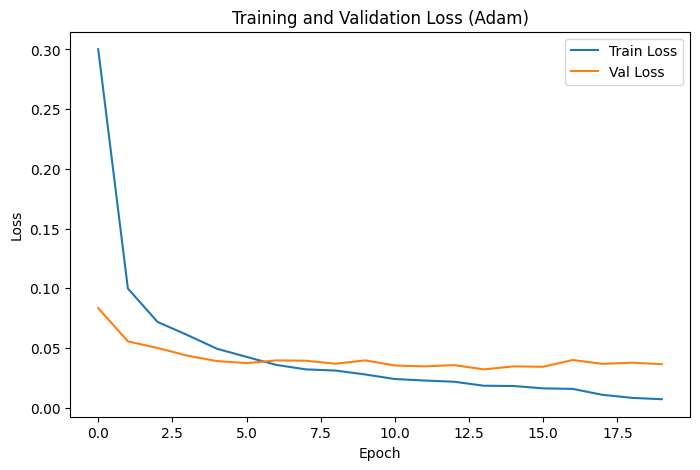

In [5]:
initial_lr = 1e-3
opt = Adam(learning_rate=initial_lr)

model = build_model()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val_cat),
    callbacks=[reduce_lr],
    verbose=2
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Adam)')
plt.legend()
plt.show()